In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 11.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 2.8 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 9.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-cp39-cp39-macosx_10_9_x86_64.whl size=251759 sha256=7968c37b6a889bc0e70ae868928e1aec16e6eb73bba4bd2acaac090ab04f36fb
  Stored in directory: /Users/sandeepvemulapalli/Library/Caches/pip/wheels/77/6b/dc/722aee2a5d46a021ab67564c9d3d5536c3bd9577fcdc3a5aeb
Successfully built peewee
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successful

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Activation
from sklearn.preprocessing import MinMaxScaler


# Define a list of stock tickers
tickers = ['VTI', 'AGG', 'DBC', 'VIX']

# Fetch historical data from Yahoo Finance
data = yf.download(tickers, start="2006-01-01", end="2019-04-30")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define a lookback window for input features
lookback_window = 15

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(lookback_window, len(tickers))))
model_gru.add(Dense(len(tickers)))
model_gru.add(Activation('softmax'))

In [3]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [4]:
X_gru, y_gru = create_gru_dataset(returns, lookback_window)

# Split the dataset into training and testing sets
train_size = int(len(X_gru) * 0.65)
X_train_gru, X_test_gru = X_gru[:train_size], X_gru[train_size:]
y_train_gru, y_test_gru = y_gru[:train_size], y_gru[train_size:]

In [5]:
model_gru.fit(X_train_gru, y_train_gru, epochs=50, batch_size=32, validation_data=(X_test_gru, y_test_gru))

Epoch 1/50
27/27 [==============================] - 5s 45ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 2/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 3/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 4/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 5/50
27/27 [==============================] - 1s 30ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 6/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 7/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 8/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 9/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 10/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 11/

In [7]:
import cvxpy as cp

expected_returns = returns.mean().values  # Convert to numpy array
cov_matrix = returns.cov().values  # Convert to numpy array

# Ensure that 'weights' is a column vector with the same number of rows as there are assets
weights = cp.Variable(expected_returns.shape[0])

# Define the optimization problem
risk_free_rate = 0.01  # Example risk-free rate
objective = cp.Maximize(expected_returns.T @ weights - risk_free_rate * cp.quad_form(weights, cov_matrix))
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal weights
optimal_weights_mpt = weights.value

In [11]:
def calculate_sharpe_ratio(returns, weights, risk_free_rate=0.0):
    expected_portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualize the return
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualize the std dev
    sharpe_ratio = (expected_portfolio_return - risk_free_rate) / portfolio_std_dev
    return sharpe_ratio

# Calculate Sharpe ratio for the MPT portfolio
sharpe_ratio_mpt = calculate_sharpe_ratio(returns, optimal_weights_mpt)


predicted_weights_gru = model_gru.predict(X_test_gru)

sharpe_ratio_gru = calculate_sharpe_ratio(returns, predicted_weights_gru.mean(axis=0))

# Print the Sharpe ratio for the GRU portfolio
print(f'Sharpe Ratio GRU: {sharpe_ratio_gru}')

# Print the Sharpe ratio for the MPT portfolio
print(f'Sharpe Ratio MPT: {sharpe_ratio_mpt}')

7/7 [==============================] - 0s 17ms/step
Sharpe Ratio GRU: -0.07806621177791913
Sharpe Ratio MPT: 0.7906344131662963


In [15]:
def simulate_portfolio_performance(weights, initial_investment, returns):
    # Calculate daily portfolio returns
    daily_returns = (weights * returns).sum(axis=1)

    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()

    # Calculate portfolio value over time
    portfolio_values = initial_investment * cumulative_returns
    return portfolio_values


initial_investment = 10000

# Simulate LSTM portfolio performance
gru_portfolio_values = simulate_portfolio_performance(predicted_weights_gru.mean(axis=0), initial_investment, returns.iloc[train_size:])

# Simulate MPT portfolio performance
mpt_portfolio_values = simulate_portfolio_performance(optimal_weights_mpt, initial_investment, returns.iloc[train_size:])

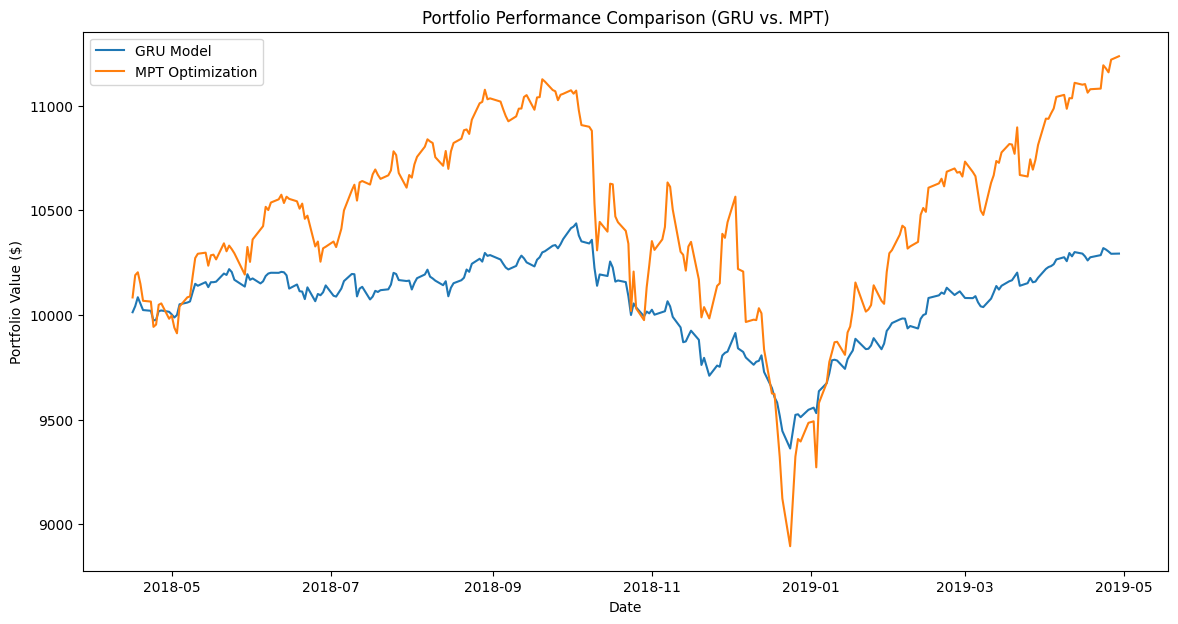

In [16]:
import matplotlib.pyplot as plt

# Plot the portfolio values over time
plt.figure(figsize=(14, 7))
plt.plot(gru_portfolio_values.index, gru_portfolio_values, label='GRU Model')
plt.plot(mpt_portfolio_values.index, mpt_portfolio_values, label='MPT Optimization')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Performance Comparison (GRU vs. MPT)')
plt.legend()

# Show the plot
plt.show()


In [19]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Activation
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

# Define a list of stock tickers
tickers = ['VTI', 'AGG', 'DBC', 'VIX']

# Fetch historical data from Yahoo Finance
data = yf.download(tickers, start="2006-01-01", end="2019-04-30")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define a lookback window for input features
lookback_window = 50

# Prepare the dataset for GRU
def create_gru_dataset(returns, lookback_window):
    X, y = [], []
    for i in range(len(returns) - lookback_window):
        X.append(returns.iloc[i:(i + lookback_window)].values)
        y.append(returns.iloc[i + lookback_window].values)
    return np.array(X), np.array(y)




<ipython-input-20-856fc47cb803>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


[*********************100%%**********************]  4 of 4 completed


In [21]:
# Create the GRU model
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        input_shape=(lookback_window, len(tickers))
    ))
    model.add(Dense(len(tickers)))
    model.add(Activation('softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mean_squared_error'
    )
    return model

# Define the Keras Tuner random search
tuner = RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=3,  # Adjust as needed
    directory='tuner_dir'  # Change to your desired directory
)

# Create the GRU dataset
X_gru, y_gru = create_gru_dataset(returns, lookback_window)

# Split the dataset into training and testing sets
train_size = int(len(X_gru) * 0.8)
X_train_gru, X_test_gru = X_gru[:train_size], X_gru[train_size:]
y_train_gru, y_test_gru = y_gru[:train_size], y_gru[train_size:]

# Perform hyperparameter tuning
tuner.search(X_train_gru, y_train_gru, epochs=50, validation_data=(X_test_gru, y_test_gru))

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Build the final model with the best hyperparameters
best_model = build_gru_model(best_hp)

# Train the final model
best_model.fit(X_train_gru, y_train_gru, epochs=50, validation_data=(X_test_gru, y_test_gru))

Trial 3 Complete [00h 03m 01s]
val_loss: 0.06248925253748894

Best val_loss So Far: 0.06248898059129715
Total elapsed time: 00h 07m 20s
Epoch 1/50
27/27 [==============================] - 5s 88ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 2/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 3/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 4/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 5/50
27/27 [==============================] - 1s 47ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 6/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 7/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 8/50
27/27 [==============================] - 1s 47ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 9/50
27/27 [==============================] - 1s 48ms/step - loss:

In [24]:
# Calculate Sharpe ratio for the MPT portfolio
sharpe_ratio_mpt = calculate_sharpe_ratio(returns, optimal_weights_mpt)


# Assuming you have already performed hyperparameter tuning and obtained the best hyperparameters and model (best_model)

# Get predictions using the best GRU model
predicted_returns_gru = best_model.predict(X_test_gru)

# Convert the predicted returns to portfolio weights (e.g., equal weights)

sharpe_ratio_gru = calculate_sharpe_ratio(returns, predicted_weights_gru.mean(axis=0))

# Print the Sharpe ratio for the best GRU model
print(f'Sharpe Ratio GRU (Best Model): {sharpe_ratio_gru}')


7/7 [==============================] - 0s 13ms/step
Sharpe Ratio GRU (Best Model): -0.07956174981333092
